In [82]:
from database import *

def ticks_to_kbars(ticks, interval='5Min'):

    kbars = pd.DataFrame()
    
    kbars['open'] = ticks['close'].resample(interval).first()
    kbars['close'] = ticks['close'].resample(interval).last()
    kbars['high'] = ticks['close'].resample(interval).max()
    kbars['low'] = ticks['close'].resample(interval).min()
    kbars['volume'] = ticks['volume'].resample(interval).sum()
    
    kbars.dropna(inplace=True)
    
    return kbars

In [83]:
import talib

def get_technical_indicator(kbars):
    
#     kbars['rsi'] = talib.RSI(kbars.close, timeperiod=14)
    kbars['cci'] = talib.CCI(kbars.high, kbars.low, kbars.close, timeperiod=14)
    
    macd, macdsignal, macdhist = talib.MACD(kbars.close, fastperiod=5, slowperiod=34, signalperiod=5)
    
    kbars['macd'] = macd
    kbars['macdsignal'] = macdsignal
    kbars['macdhist'] = macdhist
    
    return kbars

In [164]:
def day_trading_backtest(code, date, connection, api):
    
    tw_calendar = get_calendar('XTAI')
    prev_trading_date = tw_calendar.previous_close(date).date()
    
    ticks = get_ticks(code, prev_trading_date, connection, api)[0].append(get_ticks(code, date, connection, api)[0])
    kbars = ticks_to_kbars(ticks)
    if kbars.empty:
        return pd.DataFrame()
    kbars = get_technical_indicator(kbars)
    prev_close_price = kbars['close'].get(pd.to_datetime(prev_trading_date).replace(hour=13, minute=30))
    kbars = kbars[date:]
            
    entry_price = 0
    entry_time = None
    
    exit_price = 0
    exit_time = None
    
    position = 0
            
    for ts in range(len(kbars)):
#         current_time = kbars.iloc[ts].name + pd.Timedelta(minutes=5)
        current_time = kbars.iloc[ts].name
        current_price = kbars['open'][ts]
        if(ts == 0 and prev_close_price is not None and current_price >= prev_close_price * 1.04):
            break
        elif ts < 2:
            continue
        
        if (
            current_time <= date.replace(hour=9, minute=30, second=0) and
            kbars.iloc[ts-1]['macd'] < 0 and
            kbars.iloc[ts-2]['macdhist'] < 0 and
            kbars.iloc[ts-1]['macdhist'] < kbars.iloc[ts-2]['macdhist'] and
            kbars.iloc[ts-2]['cci'] < -200 and
            kbars.iloc[ts-1]['cci'] < kbars.iloc[ts-2]['cci'] and
            kbars['open'][ts-1] > kbars['close'][ts-1] and
            position == 0
        ):
            cci = kbars.iloc[ts-1]['cci']
            macd = kbars.iloc[ts-1]['macd']
            position = 2          
            entry_price = current_price
            entry_time = current_time.time()

            print('[{}] buy {} at {}'.format(current_time, code, current_price))
        
        elif (
            (current_price <= entry_price * 0.98 and position != 0) or
            (
#             kbars.iloc[ts-1]['macd'] > 0 and
#             kbars.iloc[ts-2]['macdhist'] > 0 and
#             kbars.iloc[ts-1]['macdhist'] > kbars.iloc[ts-2]['macdhist'] and
#             kbars.iloc[ts-2]['cci'] > 100 and
#             kbars.iloc[ts-1]['cci'] > kbars.iloc[ts-2]['cci'] and
#             kbars['open'][ts-1] < kbars['close'][ts-1] and
            kbars.iloc[ts-1]['cci'] > 100 and
            position != 0)
        ):
            exit_price = current_price
            exit_time = current_time.time()
            
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
        elif (
            current_time >= date.replace(hour=13, minute=20, second=0) and
            position != 0
        ):
            
            exit_price = current_price
            exit_time = current_time.time()
            
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
    if entry_time and exit_time:
        transaction = pd.DataFrame([[date, 
                                     code, 
                                     entry_time,
                                     entry_price, 
                                     position * 1000,
                                     entry_price * position * 1000,
                                     exit_time,
                                     exit_price,
                                     position * 1000,
                                     exit_price * position * 1000]
                                   ],
                                    columns=[
                                        '成交日期', 
                                        '股票代號',
                                        '買進時間',
                                        '買進價格',
                                        '買進股數',
                                        '買進金額',
                                        '賣出時間',
                                        '賣出價格',
                                        '賣出股數',
                                        '賣出金額'])
        return transaction
    else:
        return pd.DataFrame()

In [85]:
import json

with open('config.json') as f:
  config = json.load(f)

api = sj.Shioaji()
api.login(
    person_id = config['account'],
    passwd= config['password'],
    contracts_cb=lambda security_type: print(f"{repr(security_type)} fetch done."))

# api.logout()

connection = sqlite3.connect('data.db')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


Exception ignored in: <function Shioaji.__del__ at 0x7f86af38d310>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/shioaji/shioaji.py", line 652, in __del__
    self._solace.__del__()
  File "shioaji/backend/solace/api.pyx", line 1232, in shioaji.backend.solace.api.SolaceAPI.__del__
  File "shioaji/backend/solace/api.pyx", line 327, in shioaji.backend.solace.api.SolaceAPI.logout
  File "/opt/anaconda3/lib/python3.8/site-packages/shioaji/utils.py", line 49, in raise_resp_error
    raise Exception(resp)
Exception: {}


<SecurityType.Index: 'IND'> fetch done.
<SecurityType.Future: 'FUT'> fetch done.
<SecurityType.Stock: 'STK'> fetch done.
<SecurityType.Option: 'OPT'> fetch done.


In [86]:
def backtest(start_date, end_date, connection, api, discount=0.38):
    
    tw_calendar = get_calendar('XTAI')
    
    transactions = pd.DataFrame()
    update_daily_prices(start_date, end_date, connection)
    for date in pd.date_range(start_date, end_date):

        if date not in tw_calendar.opens:
            continue
        
        codes = get_stocks(date, connection)
        day_trading_codes = [code for code in codes if get_stock(code, connection, api)[0].iloc[0]['day_trade'] == 'Yes']
        
        for code in day_trading_codes:
            
            transaction = day_trading_backtest(code, pd.to_datetime(date), connection, api)
            
            if not transaction.empty:
                transactions = transactions.append(transaction)
                
    if not transactions.empty:

        transactions['買進手續費'] = transactions['買進金額'] * 0.001425 * discount
        transactions['買進手續費'] = transactions['買進手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['買進手續費'] = transactions['買進手續費'].astype(int)

        transactions['賣出手續費'] = transactions['賣出金額'] * 0.001425 * discount
        transactions['賣出手續費'] = transactions['賣出手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['賣出手續費'] = transactions['賣出手續費'].astype(int)

        transactions['交易稅'] = transactions['賣出金額'] * 0.0015
        transactions['交易稅'] = transactions['交易稅'].astype(int)

        transactions['損益'] = (transactions['賣出金額'] - transactions['買進金額']) - (transactions['買進手續費'] + transactions['賣出手續費'] + transactions['交易稅'])

        transactions = transactions.set_index(['成交日期'])
        
    return transactions

In [162]:
transactions = backtest('2020/1/1', '2020/12/31', connection, api)
transactions 

[2020-01-03 09:30:00] buy 3019 at 106.0
cci = -265.93137254902035
macd = -1.2826805156612835
[2020-01-03 10:10:00] sell 3019 at 102.0
[2020-02-19 09:15:00] buy 3515 at 106.5
cci = -332.6953748006337
macd = -2.020946084650845
[2020-02-19 11:50:00] sell 3515 at 104.0
[2020-03-31 09:15:00] buy 4551 at 111.0
cci = -287.25925925926515
macd = -0.5351937354739675
[2020-03-31 12:35:00] sell 4551 at 108.0
[2020-06-08 09:25:00] buy 5215 at 106.0
cci = -263.247863247864
macd = -0.9231130816264823
[2020-06-08 09:40:00] sell 5215 at 102.0
[2020-06-15 09:10:00] buy 9802 at 105.5
cci = -264.0350877192954
macd = -0.38467362115130754
[2020-06-15 10:35:00] sell 9802 at 106.0
[2020-07-24 09:10:00] buy 9802 at 111.0
cci = -319.7530864197525
macd = -1.2292951451891554
[2020-07-24 10:25:00] sell 9802 at 113.0
[2020-07-27 09:25:00] buy 6451 at 111.0
cci = -229.533116178065
macd = -1.3073956940163782
[2020-07-27 10:25:00] sell 6451 at 108.5
[2020-08-12 09:10:00] buy 6196 at 104.5
cci = -272.2951844903082
macd

,股票代號,買進時間,買進價格,買進股數,買進金額,賣出時間,賣出價格,賣出股數,賣出金額,買進手續費,賣出手續費,交易稅,損益
成交日期,,,,,,,,,,,,,
2020-01-03,3019,09:30:00,106.0,2000,212000.0,10:10:00,102.0,2000,204000.0,114,110,306,-8530.0
2020-02-19,3515,09:15:00,106.5,2000,213000.0,11:50:00,104.0,2000,208000.0,115,112,312,-5539.0
2020-03-31,4551,09:15:00,111.0,2000,222000.0,12:35:00,108.0,2000,216000.0,120,116,324,-6560.0
2020-06-08,5215,09:25:00,106.0,2000,212000.0,09:40:00,102.0,2000,204000.0,114,110,306,-8530.0
2020-06-15,9802,09:10:00,105.5,2000,211000.0,10:35:00,106.0,2000,212000.0,114,114,318,454.0
2020-07-24,9802,09:10:00,111.0,2000,222000.0,10:25:00,113.0,2000,226000.0,120,122,339,3419.0
2020-07-27,6451,09:25:00,111.0,2000,222000.0,10:25:00,108.5,2000,217000.0,120,117,325,-5562.0
2020-08-12,6196,09:10:00,104.5,2000,209000.0,10:45:00,106.0,2000,212000.0,113,114,318,2455.0
2020-08-14,2723,09:30:00,112.0,2000,224000.0,11:00:00,112.0,2000,224000.0,121,121,336,-578.0


In [156]:
daily_profit_loss = transactions.resample('D').sum()
daily_profit_loss['交易次數'] = transactions.groupby('成交日期').size()
daily_profit_loss = daily_profit_loss[['買進金額', '買進手續費', '賣出金額', '賣出手續費', '交易稅', '損益', '交易次數']]
daily_profit_loss.dropna(inplace=True) 

daily_profit_loss

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2021-01-08,196400.0,106,196800.0,106,295,-107.0,1.0
2021-01-15,203000.0,109,203000.0,109,304,-522.0,1.0
2021-01-18,199000.0,107,204000.0,110,306,4477.0,1.0
2021-01-20,203000.0,109,202000.0,109,303,-1521.0,1.0
2021-02-04,211000.0,114,216000.0,116,324,4446.0,1.0
2021-02-23,212000.0,114,222000.0,120,333,9433.0,1.0
2021-03-05,198400.0,107,198600.0,107,297,-311.0,1.0


In [157]:
monthly_profit_loss = daily_profit_loss.resample('M').sum()
monthly_profit_loss 

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2021-01-31,801400.0,431,805800.0,434,1208,2327.0,4.0
2021-02-28,423000.0,228,438000.0,236,657,13879.0,2.0
2021-03-31,198400.0,107,198600.0,107,297,-311.0,1.0


In [158]:
# 總損益
profit_loss = daily_profit_loss['損益'].sum()
profit_loss

15895.0

In [159]:
# 勝率
win_rate = round(len(transactions[transactions['損益'] > 0]) / len(transactions), 3)
win_rate

0.429

In [160]:
# 最大連續虧損
con_loss = 0
max_loss = 0

for profit_loss in daily_profit_loss["損益"]:
    
    if profit_loss < 0:
        con_loss += profit_loss
    else:
        con_loss = 0
        continue
    
    if con_loss < max_loss:
        max_loss = con_loss
        
print('最大連續虧損', max_loss)

最大連續虧損 -1521.0


[Text(0.5, 0, 'profit loss')]

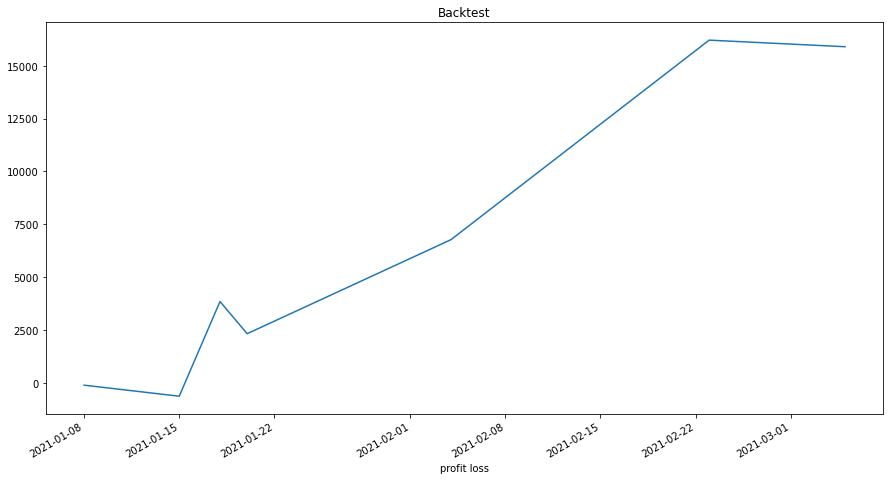

In [161]:
daily_profit_loss['損益'].cumsum()
daily_profit_loss['損益'].cumsum().plot(title='Backtest', figsize=(15, 8)).set(xlabel='profit loss')